# Batting Statistics Analysis

This notebook provides comprehensive analysis of batting statistics using the BaseballDataLoader. We focus on modern analytics that prioritize meaningful stats over traditional metrics.

## Key Statistics Explained
- **AVG (Batting Average)**: Hits per at-bat - traditional but limited metric
- **OBP (On-Base Percentage)**: Rate of reaching base safely - more valuable than AVG
- **OPS (On-Base Plus Slugging)**: Combined measure of getting on base and hitting for power
- **wRC+ (Weighted Runs Created Plus)**: Context-adjusted offensive value (100 = league average)
- **ISO (Isolated Power)**: Measure of raw power (SLG - AVG)
- **K-BB% (Strikeout minus Walk Rate)**: Plate discipline indicator
- **WAR (Wins Above Replacement)**: Total player value compared to replacement level
  - **fWAR (FanGraphs)**: Most widely used, incorporates FIP and UZR
  - **bWAR (Baseball Reference)**: Alternative calculation using RA9 and DRS

In [21]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# Import baseball stats data loader
# Import our baseball analytics functions
from src.baseball_stats import BaseballDataLoader

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

In [22]:
# Configure global logging level to INFO
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# Set root logger to INFO to suppress DEBUG logs from all libraries
logging.getLogger().setLevel(logging.INFO)

In [23]:
# Initialize data loader with 2025 data and qualified thresholds
print("Loading 2025 batting data for qualified hitters (100+ PA)...")
loader = BaseballDataLoader(year=2025, min_pa=100, min_ip=20)
loader.load_all()

# Get hitting data - try multiple methods to ensure we get data
hitting_data = None
try:
    # Try qualified hitters first
    hitting_data = loader.hitting_qualified
    print(f"Loaded qualified hitting data: {len(hitting_data)} players")
except Exception as e:
    print(f"Error loading qualified data: {e}")
    try:
        # Fallback to raw data
        hitting_data = loader.hitting_raw
        # Filter for qualified hitters manually
        if 'PA' in hitting_data.columns:
            hitting_data = hitting_data[hitting_data['PA'] >= 100]
        print(f"Loaded raw hitting data (filtered): {len(hitting_data)} players")
    except Exception as e2:
        print(f"Error loading raw data: {e2}")
        # Try FanGraphs data as last resort
        try:
            hitting_data = loader.hitting_fangraphs
            if hitting_data is not None:
                print(f"Loaded FanGraphs hitting data: {len(hitting_data)} players")
            else:
                print("No hitting data available")
        except Exception as e3:
            print(f"Error loading FanGraphs data: {e3}")

if hitting_data is not None and not hitting_data.empty:
    print(f"Final dataset: {len(hitting_data)} qualified hitters")
    
    # Check for WAR columns
    war_columns = [col for col in hitting_data.columns if 'WAR' in col.upper()]
    
    # Display available columns with WAR highlighted
    print(f"\n📊 AVAILABLE DATA COLUMNS:")
    print(f"Total columns: {len(hitting_data.columns)}")
    
    # Show key offensive stats
    offensive_stats = ['AVG', 'OBP', 'OPS', 'wRC+', 'ISO', 'HR', 'RBI', 'R', 'H', 'AB', 'PA']
    available_offensive = [stat for stat in offensive_stats if stat in hitting_data.columns]
    if available_offensive:
        print(f"\n⚾ Offensive Stats: {', '.join(available_offensive)}")
    
    # Show WAR metrics separately
    if war_columns:
        print(f"\n🏆 WAR Metrics Found: {', '.join(war_columns)}")
        for war_col in war_columns:
            non_null = hitting_data[war_col].notna().sum()
            print(f"   • {war_col}: {non_null} players with data")
    
    # Show plate discipline stats
    discipline_stats = ['BB%', 'K%', 'BB', 'SO', 'SwStr%', 'Contact%']
    available_discipline = [stat for stat in discipline_stats if stat in hitting_data.columns]
    if available_discipline:
        print(f"\n🎯 Plate Discipline: {', '.join(available_discipline)}")
    
    # Show advanced stats
    advanced_stats = ['wOBA', 'BABIP', 'SLG', 'ISO', 'Barrel%', 'HardHit%']
    available_advanced = [stat for stat in advanced_stats if stat in hitting_data.columns]
    if available_advanced:
        print(f"\n📈 Advanced Stats: {', '.join(available_advanced)}")
    
    # Show first 20 columns for reference
    print(f"\n📋 First 20 columns: {list(hitting_data.columns)[:20]}...")
else:
    print("⚠️ No hitting data could be loaded. This might be due to network issues or data availability.")

Loading 2025 batting data for qualified hitters (100+ PA)...
🚀 Loading all baseball data for 2025...
📊 Loading hitting data...
Fetching baserunning metrics for 2025...
Error getting baserunning data: 'module' object is not callable
⚾ Loading pitching data...
🏟️ Loading team data...
📡 Loading Statcast data...
🧤 Loading fielding data...
Fetching fielding metrics for 2025...
Error getting fielding data: 'module' object is not callable
✅ All data loaded successfully!

📊 Data Summary:
Year: 2025

Hitting Data:
  - raw: 158 records
  - qualified: 158 records
  - fangraphs: 361 records
  - sprint_speed: 493 records

Pitching Data:
  - raw: 71 records
  - qualified: 71 records
  - fangraphs: 405 records

Team Data:
  - stats: loaded
  - standings: loaded

Statcast Data:
  - recent: 117515 records
  - bat_tracking: 54790 records
Loaded qualified hitting data: 158 players
Final dataset: 158 qualified hitters

📊 AVAILABLE DATA COLUMNS:
Total columns: 320

⚾ Offensive Stats: AVG, OBP, OPS, wRC+, I

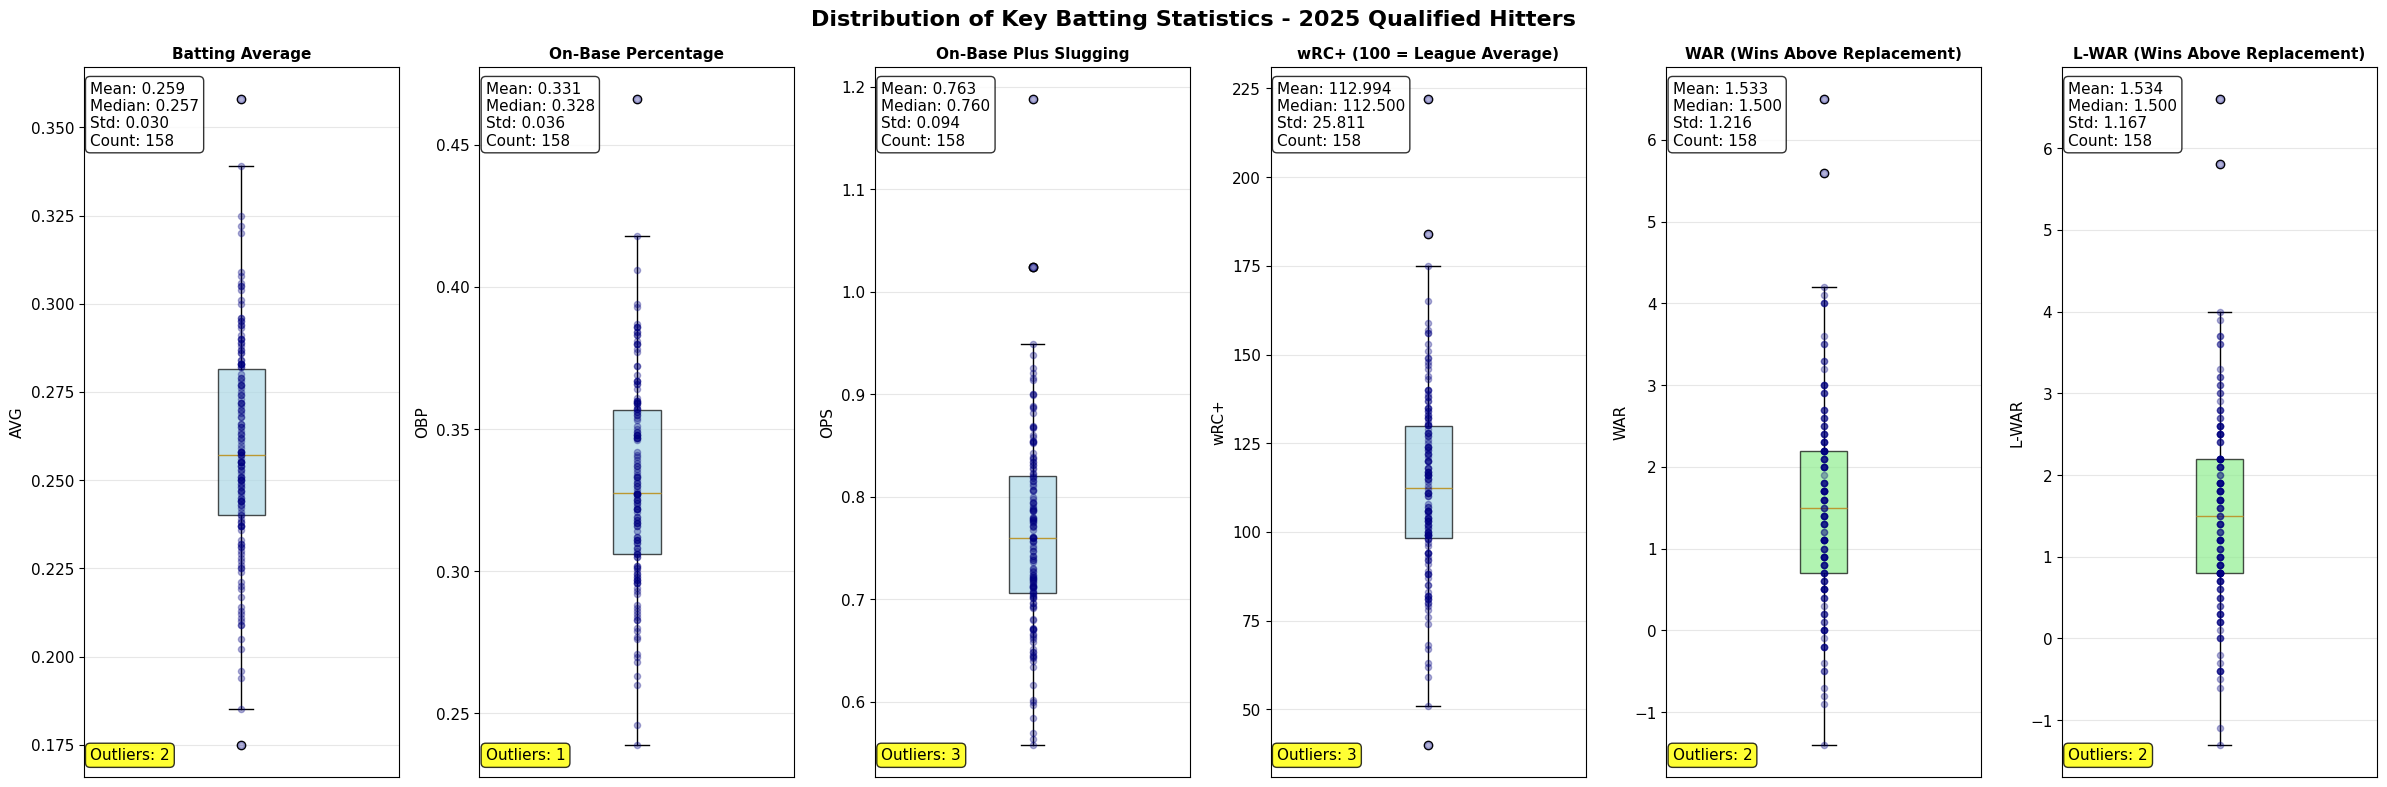

In [24]:
# Create horizontal box plots for distribution analysis (including WAR)
if hitting_data is not None and not hitting_data.empty:
    # Check for WAR columns
    war_columns = [col for col in hitting_data.columns if 'WAR' in col.upper()]
    
    # Define the statistics to plot
    stats_to_plot = [
        ('AVG', 'Batting Average'),
        ('OBP', 'On-Base Percentage'),
        ('OPS', 'On-Base Plus Slugging'),
        ('wRC+', 'wRC+ (100 = League Average)')
    ]
    
    # Add WAR columns to the plot list
    if war_columns:
        # Add the first WAR column found (usually fWAR or bWAR)
        for war_col in war_columns[:2]:  # Limit to 2 WAR metrics to keep plot manageable
            if war_col in hitting_data.columns:
                stats_to_plot.append((war_col, f'{war_col} (Wins Above Replacement)'))
    
    # Filter to only include available statistics
    available_stats = [(stat, title) for stat, title in stats_to_plot if stat in hitting_data.columns]
    
    if available_stats:
        # Adjust figure size based on number of plots
        fig, axes = plt.subplots(1, len(available_stats), figsize=(4*len(available_stats), 8))
        fig.suptitle('Distribution of Key Batting Statistics - 2025 Qualified Hitters', fontsize=16, fontweight='bold')
        
        # Handle case where there's only one plot
        if len(available_stats) == 1:
            axes = [axes]
        
        # Create box plots for each statistic
        for i, (stat, title) in enumerate(available_stats):
            ax = axes[i]
            
            # Clean data
            data_clean = hitting_data[stat].dropna()
            
            if len(data_clean) > 0:
                # Create box plot
                bp = ax.boxplot(data_clean, patch_artist=True, vert=True)
                
                # Color the box plot (different color for WAR)
                if 'WAR' in stat:
                    bp['boxes'][0].set_facecolor('lightgreen')
                else:
                    bp['boxes'][0].set_facecolor('lightblue')
                bp['boxes'][0].set_alpha(0.7)
                
                # Add scatter plot of actual data points
                y_data = data_clean.values
                x_data = [1] * len(y_data)  # All points at x=1
                ax.scatter(x_data, y_data, alpha=0.3, color='navy', s=20, zorder=3)
                
                # Formatting
                ax.set_title(title, fontweight='bold', fontsize=11)
                ax.set_ylabel(stat, fontsize=11)
                ax.grid(True, alpha=0.3)
                ax.set_xticks([])  # Remove x-axis ticks since we only have one box
                
                # Add summary statistics as text
                stats_text = f'Mean: {data_clean.mean():.3f}\nMedian: {data_clean.median():.3f}\nStd: {data_clean.std():.3f}\nCount: {len(data_clean)}'
                ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                
                # Highlight outliers
                Q1 = data_clean.quantile(0.25)
                Q3 = data_clean.quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                outliers = data_clean[(data_clean < lower_bound) | (data_clean > upper_bound)]
                if len(outliers) > 0:
                    ax.text(0.02, 0.02, f'Outliers: {len(outliers)}', transform=ax.transAxes, 
                            verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
            else:
                ax.text(0.5, 0.5, f'{stat} has no valid data', 
                        transform=ax.transAxes, ha='center', va='center')
                ax.set_title(title, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ None of the standard statistics (AVG, OBP, OPS, wRC+, WAR) are available in the dataset")
        print("Available columns:", list(hitting_data.columns)[:10])
else:
    print("⚠️ Cannot create distribution plots - no hitting data available")

In [25]:
# Display summary statistics for key metrics including WAR
if hitting_data is not None and not hitting_data.empty:
    print("\n=== BATTING STATISTICS SUMMARY (2025 Qualified Hitters) ===")
    print("\nKey Statistics Overview:")
    
    # Check for available WAR columns
    war_columns = [col for col in hitting_data.columns if 'WAR' in col.upper()]
    
    # Calculate summary stats for available metrics (including WAR)
    summary_stats = ['AVG', 'OBP', 'OPS', 'wRC+', 'ISO', 'BB%', 'K%', 'SLG', 'wOBA', 'BABIP']
    
    available_stats = [stat for stat in summary_stats if stat in hitting_data.columns]
    
    if available_stats:
        summary_df = hitting_data[available_stats].describe()
        display(summary_df.round(3))
        
        print(f"\n📊 Summary: Found {len(available_stats)} key statistics for {len(hitting_data)} players")
        print(f"Available stats: {', '.join(available_stats)}")
    else:
        print("Standard statistics not found. Available columns:")
        print(list(hitting_data.columns)[:20])  # Show first 20 columns
        print(f"\nTotal columns available: {len(hitting_data.columns)}")
else:
    print("⚠️ Cannot display summary statistics - no hitting data available")


=== BATTING STATISTICS SUMMARY (2025 Qualified Hitters) ===

Key Statistics Overview:


,AVG,OBP,OPS,wRC+,ISO,BB%,K%,SLG,wOBA,BABIP
count,158.000,158.000,158.000,158.000,158.000,158.000,158.000,158.000,158.000,158.000
mean,0.259,0.331,0.763,112.994,0.173,0.090,0.208,0.432,0.333,0.300
std,0.030,0.036,0.094,25.811,0.057,0.032,0.059,0.069,0.036,0.037
min,0.175,0.239,0.558,40.000,0.041,0.025,0.021,0.298,0.244,0.199
25%,0.240,0.306,0.706,98.250,0.133,0.066,0.167,0.387,0.310,0.275
50%,0.257,0.328,0.760,112.500,0.167,0.085,0.210,0.422,0.334,0.298
75%,0.282,0.357,0.820,129.750,0.209,0.110,0.251,0.474,0.355,0.323
max,0.358,0.466,1.188,222.000,0.369,0.183,0.387,0.722,0.486,0.439



📊 Summary: Found 10 key statistics for 158 players
Available stats: AVG, OBP, OPS, wRC+, ISO, BB%, K%, SLG, wOBA, BABIP


## Section 2: Single Player Investigation

Let's dive deep into a single player's complete batting profile. We'll examine both traditional and modern metrics to get a comprehensive view of their offensive performance.

### Player Selection
We'll analyze a notable player's 2025 performance, showcasing both traditional stats and advanced analytics.

In [26]:
# Select a notable player for analysis (including WAR in sorting options)
if hitting_data is not None and not hitting_data.empty:
    print("Top 10 hitters by available offensive metrics:")
    print("\n=== Available Columns ===")
    print(f"Total columns: {len(hitting_data.columns)}")
    
    # Check for WAR columns
    war_columns = [col for col in hitting_data.columns if 'WAR' in col.upper()]
    
    # Try to identify a good sorting column (prioritize WAR if available)
    sort_candidates = []
    if war_columns:
        sort_candidates.extend(war_columns[:1])  # Add first WAR column as primary sort option
    sort_candidates.extend(['wRC+', 'OPS', 'wOBA', 'SLG'])
    
    sort_column = None
    for candidate in sort_candidates:
        if candidate in hitting_data.columns:
            sort_column = candidate
            break
    
    if sort_column:
        print(f"\n🏆 Top 10 players by {sort_column}:")
        # Clean data before sorting
        clean_data = hitting_data.dropna(subset=[sort_column])
        if len(clean_data) > 0:
            top_players = clean_data.nlargest(10, sort_column)
            
            # Find name column
            name_cols = [col for col in hitting_data.columns if 'name' in col.lower() or col in ['Name', 'Player', 'player_name']]
            display_cols = name_cols[:1] if name_cols else []
            
            # Add key stats including WAR
            key_display_stats = ['AVG', 'OBP', 'OPS', 'SLG', 'wRC+']
            # Add WAR columns to display
            if war_columns:
                key_display_stats.extend(war_columns[:2])  # Show up to 2 WAR metrics
            
            # Only include columns that exist
            display_cols.extend([col for col in key_display_stats if col in hitting_data.columns])
            
            # Make sure we include the sort column if it's not already there
            if sort_column not in display_cols:
                display_cols.append(sort_column)
            
            if display_cols:
                display(top_players[display_cols])
                
                # If WAR was the sort column, provide context
                if 'WAR' in sort_column:
                    print(f"\n📊 Sorted by {sort_column} - Higher WAR indicates more overall value to the team")
                    print("WAR Scale: 0-1 (Replacement), 2-3 (Solid Starter), 3-5 (All-Star), 5+ (MVP candidate)")
            else:
                print("Player names not available in standard format")
                display(top_players.head())
        else:
            print(f"No valid data for {sort_column}")
    else:
        print("\nStandard sorting columns not found. Showing first few players:")
        display(hitting_data.head())
else:
    print("⚠️ Cannot display top players - no hitting data available")

Top 10 hitters by available offensive metrics:

=== Available Columns ===
Total columns: 320

🏆 Top 10 players by WAR:


,Name,AVG,OBP,OPS,SLG,wRC+,WAR,L-WAR
0,Aaron Judge,0.358,0.466,1.188,0.722,222,6.5,6.6
2,Cal Raleigh,0.272,0.383,1.024,0.641,184,5.6,5.8
1,Shohei Ohtani,0.287,0.387,1.024,0.637,175,4.2,4.0
14,Jeremy Pena,0.322,0.378,0.867,0.489,146,4.1,3.9
6,Kyle Tucker,0.290,0.393,0.926,0.533,156,4.0,3.6
39,Pete Crow-Armstrong,0.265,0.301,0.837,0.537,130,4.0,3.7
42,Bobby Witt Jr.,0.286,0.338,0.827,0.490,123,4.0,3.7
47,Trea Turner,0.295,0.347,0.800,0.453,122,3.6,3.3
4,James Wood,0.283,0.386,0.938,0.552,156,3.5,3.6
9,Corbin Carroll,0.255,0.341,0.914,0.573,148,3.5,3.1



📊 Sorted by WAR - Higher WAR indicates more overall value to the team
WAR Scale: 0-1 (Replacement), 2-3 (Solid Starter), 3-5 (All-Star), 5+ (MVP candidate)


In [27]:
# Select a specific player for detailed analysis
if hitting_data is not None and not hitting_data.empty:
    target_player = None
    
    # Find name column
    name_column = None
    for col in hitting_data.columns:
        if 'name' in col.lower() or col in ['Name', 'Player', 'player_name']:
            name_column = col
            break
    
    if name_column:
        print(f"Found name column: {name_column}")
        
        # Prompt user for player selection
        print("\n🎯 PLAYER SELECTION")
        print("=" * 30)
        print("Enter a player name to analyze, or type 'random' for a random selection:")
        print("Examples: 'Aaron Judge', 'Juan Soto', 'Mookie Betts', 'random'")
        
        # Get user input
        user_input = input("\nEnter player name (or 'random'): ").strip()
        
        if user_input.lower() == 'random':
            # Select random player
            import random
            random_index = random.randint(0, len(hitting_data) - 1)
            target_player = hitting_data.iloc[random_index]
            print(f"🎲 Randomly selected: {target_player[name_column]}")
        else:
            # Search for specific player
            print(f"🔍 Searching for: {user_input}")
            
            # Try exact match first
            exact_matches = hitting_data[hitting_data[name_column].str.contains(user_input, na=False, case=False)]
            
            if len(exact_matches) > 0:
                if len(exact_matches) == 1:
                    target_player = exact_matches.iloc[0]
                    print(f"✅ Found exact match: {target_player[name_column]}")
                else:
                    print(f"📋 Found {len(exact_matches)} matches:")
                    for i, (_, player) in enumerate(exact_matches.head(10).iterrows()):
                        print(f"  {i+1}. {player[name_column]}")
                    
                    # Use first match
                    target_player = exact_matches.iloc[0]
                    print(f"🎯 Using first match: {target_player[name_column]}")
            else:
                # Try partial match with last name
                if ' ' in user_input:
                    last_name = user_input.split()[-1]
                    print(f"🔍 Trying last name search: {last_name}")
                    partial_matches = hitting_data[hitting_data[name_column].str.contains(last_name, na=False, case=False)]
                    
                    if len(partial_matches) > 0:
                        target_player = partial_matches.iloc[0]
                        print(f"✅ Found partial match: {target_player[name_column]}")
                    else:
                        print(f"❌ No matches found for '{user_input}'")
                else:
                    print(f"❌ No matches found for '{user_input}'")
    else:
        print("⚠️ Name column not found in dataset")
    
    # If no player found, fall back to top performer
    if target_player is None:
        print("\n🔄 Falling back to top performer...")
        if 'wRC+' in hitting_data.columns:
            clean_data = hitting_data.dropna(subset=['wRC+'])
            if len(clean_data) > 0:
                target_player = clean_data.loc[clean_data['wRC+'].idxmax()]
                player_name_display = target_player.get(name_column, 'Unknown Player') if name_column else 'Top Performer'
                print(f"📊 Using top performer by wRC+: {player_name_display}")
            else:
                target_player = hitting_data.iloc[0]
                print("Using first player in dataset")
        else:
            target_player = hitting_data.iloc[0]
            print("Using first player in dataset")
    
    if target_player is not None:
        player_name_display = target_player.get(name_column, 'Unknown Player') if name_column else 'Player (name not available)'
        print(f"\n🎯 Selected player for analysis: {player_name_display}")
        print("=" * 50)
    else:
        print("⚠️ Could not select a player for analysis")
else:
    print("⚠️ Cannot select player - no hitting data available")
    target_player = None
    name_column = None

Found name column: Name

🎯 PLAYER SELECTION
Enter a player name to analyze, or type 'random' for a random selection:
Examples: 'Aaron Judge', 'Juan Soto', 'Mookie Betts', 'random'
🔍 Searching for: Julio Rodriguez
✅ Found exact match: Julio Rodriguez

🎯 Selected player for analysis: Julio Rodriguez


In [28]:
# Create comprehensive player profile
def create_player_profile(player_data, name_col):
    """Create a formatted display of player statistics"""
    if player_data is None:
        print("⚠️ No player data available for profile creation")
        return
    
    print("=" * 60)
    print(f"COMPLETE BATTING PROFILE - 2025 SEASON")
    print("=" * 60)
    
    # Player identification
    if name_col and name_col in player_data.index:
        print(f"Player: {player_data[name_col]}")
    else:
        print("Player: [Name not available]")
    
    # Traditional Statistics
    print("\n📊 TRADITIONAL STATISTICS")
    print("-" * 30)
    traditional_stats = {
        'AVG': 'Batting Average',
        'HR': 'Home Runs',
        'RBI': 'Runs Batted In',
        'R': 'Runs Scored',
        'H': 'Hits',
        'AB': 'At Bats',
        'PA': 'Plate Appearances'
    }
    
    found_traditional = False
    for stat, description in traditional_stats.items():
        if stat in player_data.index:
            value = player_data[stat]
            if pd.notna(value):
                found_traditional = True
                if stat in ['AVG']:
                    print(f"{description:.<20} {value:.3f}")
                else:
                    print(f"{description:.<20} {value:.0f}")
    
    if not found_traditional:
        print("Traditional statistics not available")
    
    # Modern Analytics (including WAR)
    print("\n🔬 MODERN ANALYTICS")
    print("-" * 30)
    modern_stats = {
        'wRC+': 'Weighted Runs Created Plus',
        'OBP': 'On-Base Percentage',
        'SLG': 'Slugging Percentage',
        'OPS': 'On-Base Plus Slugging',
        'ISO': 'Isolated Power',
        'BABIP': 'Batting Avg on Balls in Play',
        'wOBA': 'Weighted On-Base Average'
    }
    
    # Add WAR columns dynamically
    war_columns = [col for col in player_data.index if 'WAR' in str(col).upper()]
    for war_col in war_columns:
        modern_stats[war_col] = war_col
    
    found_modern = False
    for stat, description in modern_stats.items():
        if stat in player_data.index:
            value = player_data[stat]
            if pd.notna(value):
                found_modern = True
                if stat == 'wRC+':
                    print(f"{description:.<25} {value:.0f} (100 = avg)")
                elif 'WAR' in stat:
                    print(f"{description:.<25} {value:.1f}")
                else:
                    print(f"{description:.<25} {value:.3f}")
    
    if not found_modern:
        print("Modern analytics not available")
    
    # Plate Discipline
    print("\n🎯 PLATE DISCIPLINE")
    print("-" * 30)
    discipline_stats = {
        'BB%': 'Walk Rate',
        'K%': 'Strikeout Rate',
        'SwStr%': 'Swinging Strike Rate',
        'Contact%': 'Contact Rate',
        'Zone%': 'Zone Rate',
        'Swing%': 'Swing Rate'
    }
    
    found_discipline = False
    for stat, description in discipline_stats.items():
        if stat in player_data.index:
            value = player_data[stat]
            if pd.notna(value):
                found_discipline = True
                print(f"{description:.<20} {value:.1f}%")
    
    if not found_discipline:
        print("Plate discipline metrics not available")
    
    # Statcast Metrics (if available)
    print("\n🚀 STATCAST METRICS")
    print("-" * 30)
    statcast_stats = {
        'Exit Velocity': 'Average Exit Velocity',
        'Launch Angle': 'Average Launch Angle',
        'Barrel%': 'Barrel Rate',
        'HardHit%': 'Hard Hit Rate',
        'Pull%': 'Pull Rate',
        'Cent%': 'Center Rate',
        'Oppo%': 'Opposite Field Rate',
        'Sprint Speed': 'Sprint Speed'
    }
    
    statcast_found = False
    for stat, description in statcast_stats.items():
        if stat in player_data.index:
            value = player_data[stat]
            if pd.notna(value):
                statcast_found = True
                if 'Speed' in stat:
                    print(f"{description:.<25} {value:.1f} ft/sec")
                elif 'Velocity' in stat:
                    print(f"{description:.<25} {value:.1f} mph")
                elif 'Angle' in stat:
                    print(f"{description:.<25} {value:.1f}°")
                elif '%' in stat:
                    print(f"{description:.<25} {value:.1f}%")
                else:
                    print(f"{description:.<25} {value:.3f}")
    
    if not statcast_found:
        print("Statcast metrics not available in dataset")
    
    print("\n" + "=" * 60)

# Display the complete player profile
if target_player is not None:
    create_player_profile(target_player, name_column)
else:
    print("⚠️ Cannot create player profile - no player selected")

COMPLETE BATTING PROFILE - 2025 SEASON
Player: Julio Rodriguez

📊 TRADITIONAL STATISTICS
------------------------------
Batting Average..... 0.255
Home Runs........... 11
Runs Batted In...... 42
Runs Scored......... 52
Hits................ 89
At Bats............. 349
Plate Appearances... 381

🔬 MODERN ANALYTICS
------------------------------
Weighted Runs Created Plus 107 (100 = avg)
On-Base Percentage....... 0.312
Slugging Percentage...... 0.401
On-Base Plus Slugging.... 0.713
Isolated Power........... 0.146
Batting Avg on Balls in Play 0.299
Weighted On-Base Average. 0.313
WAR...................... 2.5
L-WAR.................... 2.2

🎯 PLATE DISCIPLINE
------------------------------
Walk Rate........... 0.1%
Strikeout Rate...... 0.2%
Swinging Strike Rate 0.2%
Contact Rate........ 0.7%
Zone Rate........... 0.4%
Swing Rate.......... 0.6%

🚀 STATCAST METRICS
------------------------------
Barrel Rate.............. 0.1%
Hard Hit Rate............ 0.4%
Pull Rate................ 0.4%
Center 